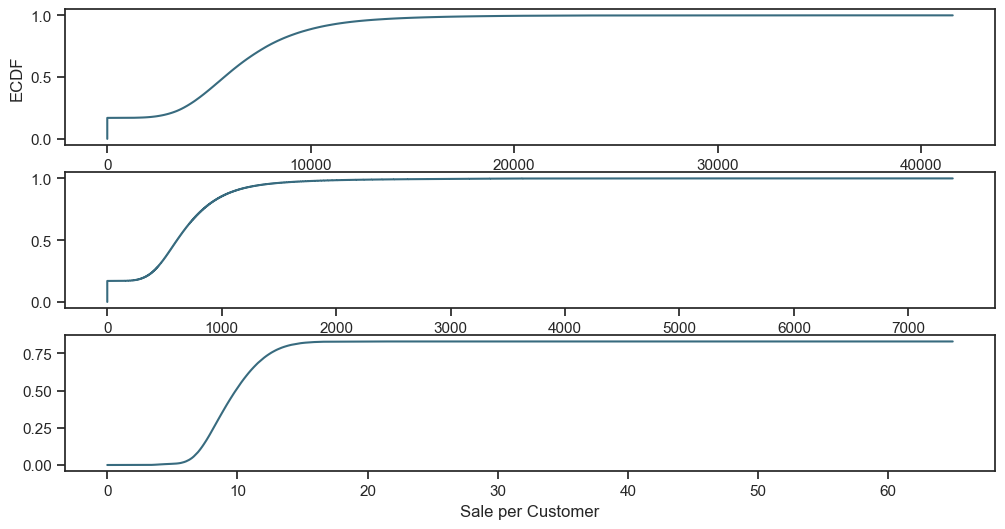

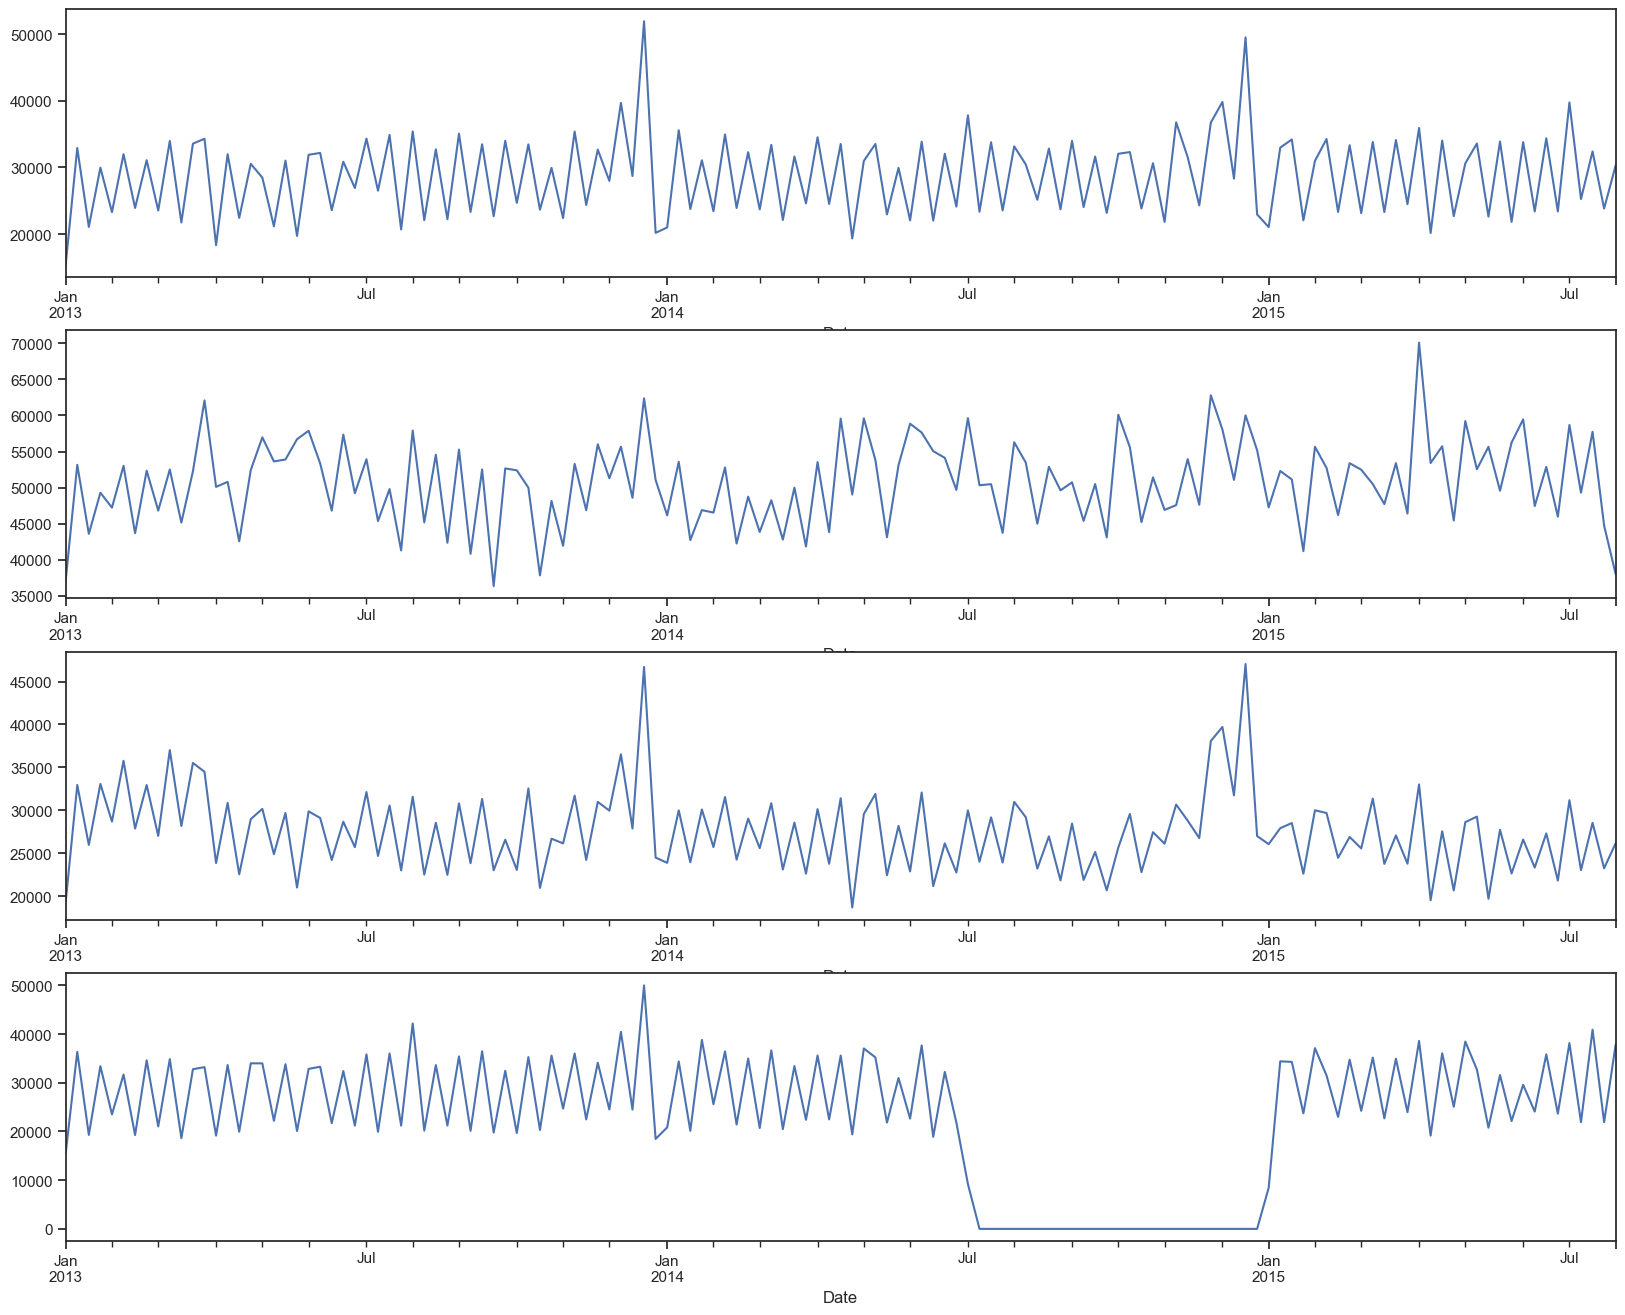

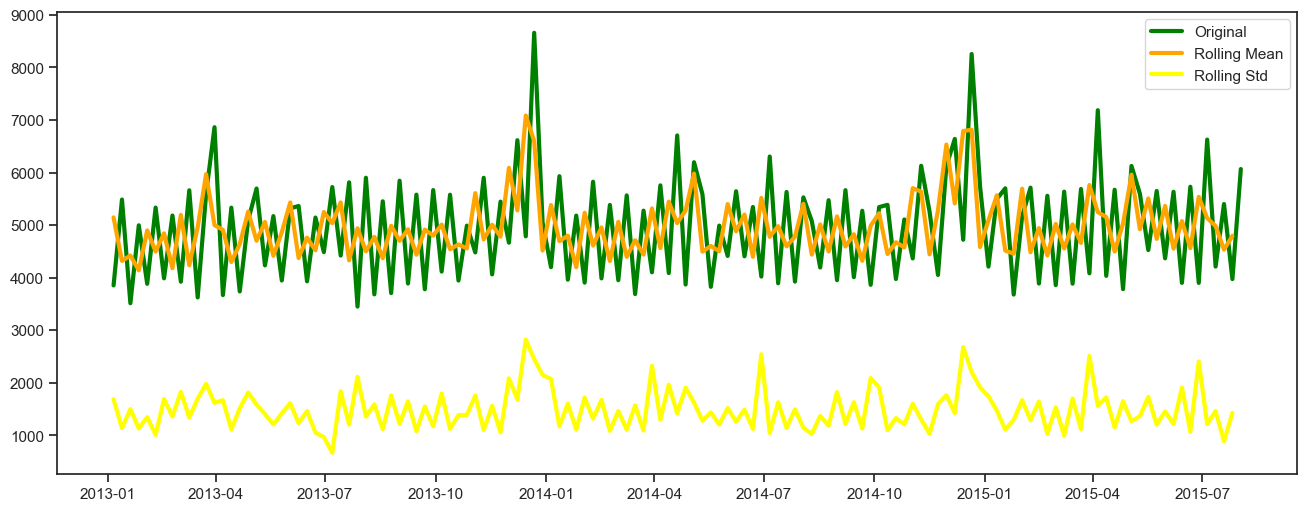

ADF Statistics: -5.292708
P-value: 0.000006
1% -3.438915730045254
5% -2.8653205426302253
10% -2.5687831424305845


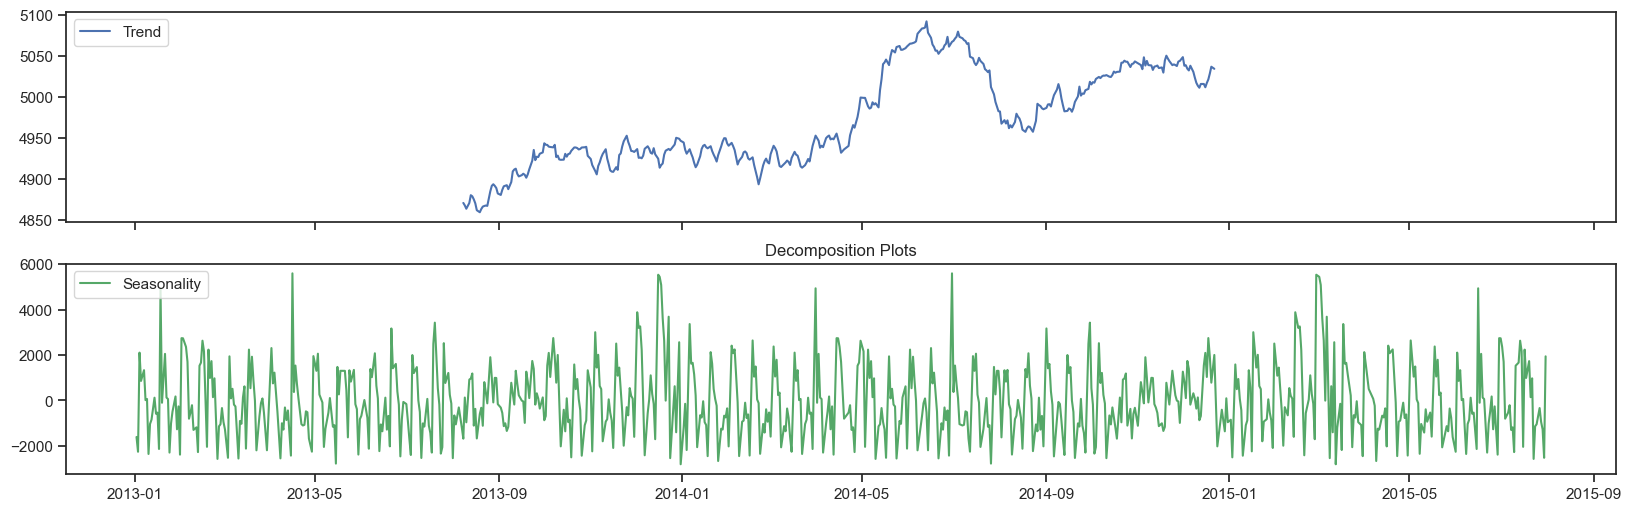

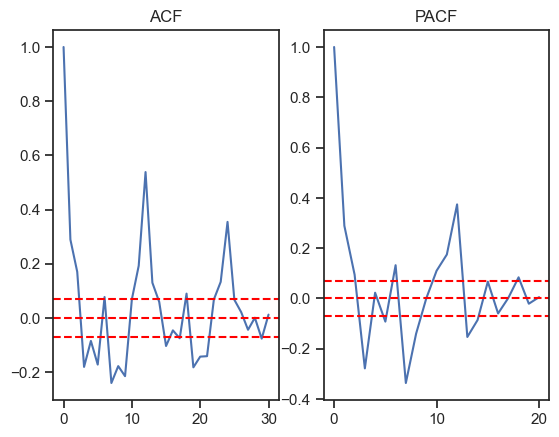

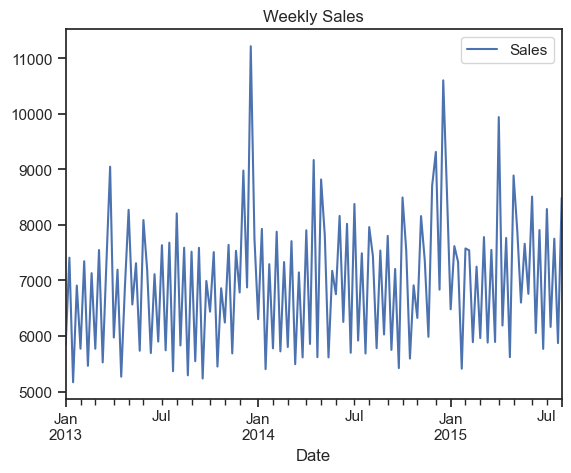

ARIMA Order: (4, 1, 1)
Seasonal Order: (0, 0, 1, 12)


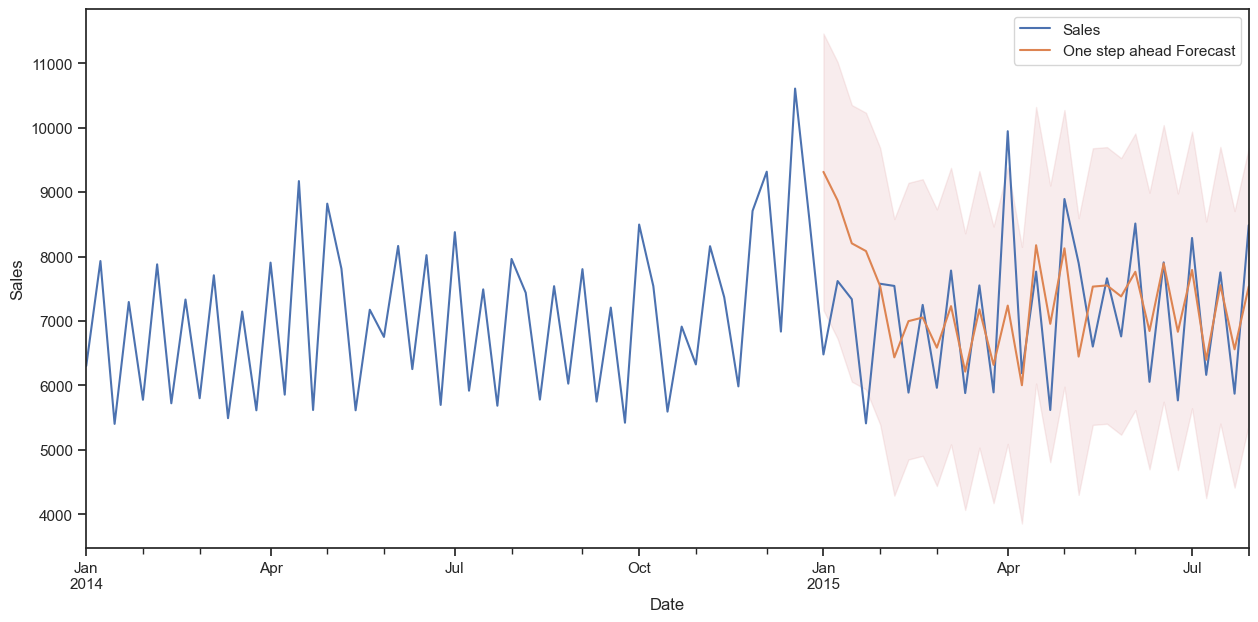

Root Mean Squared Error =  1112.7663615899203


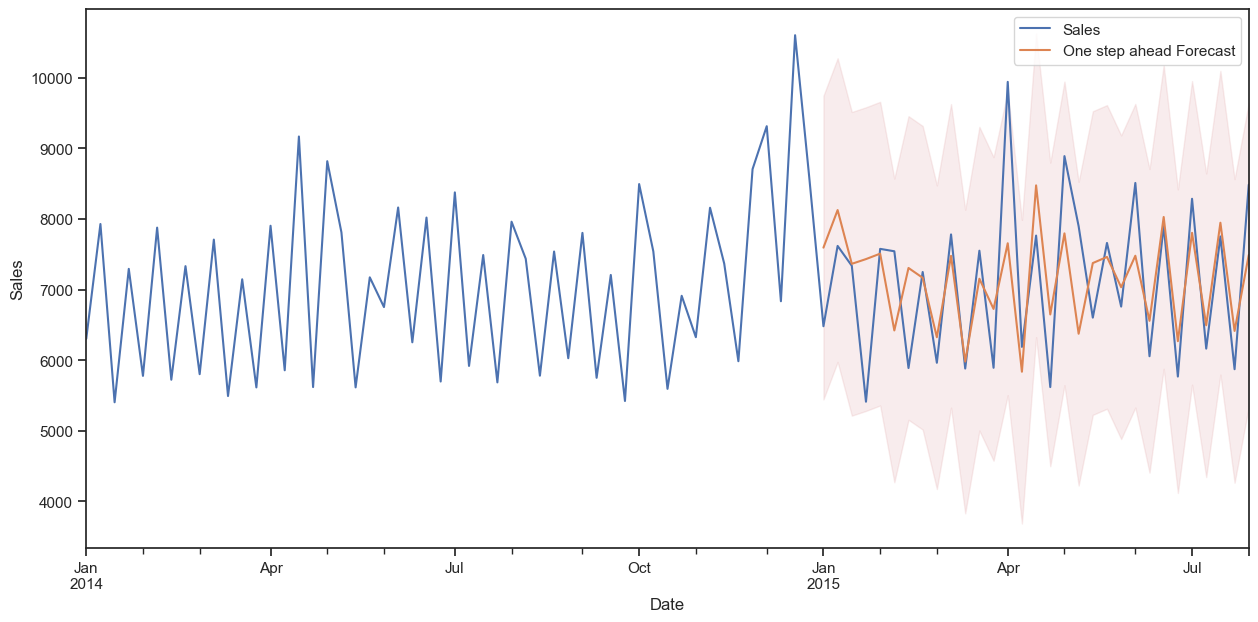

Root Mean Squared Error =  886.3070674209079


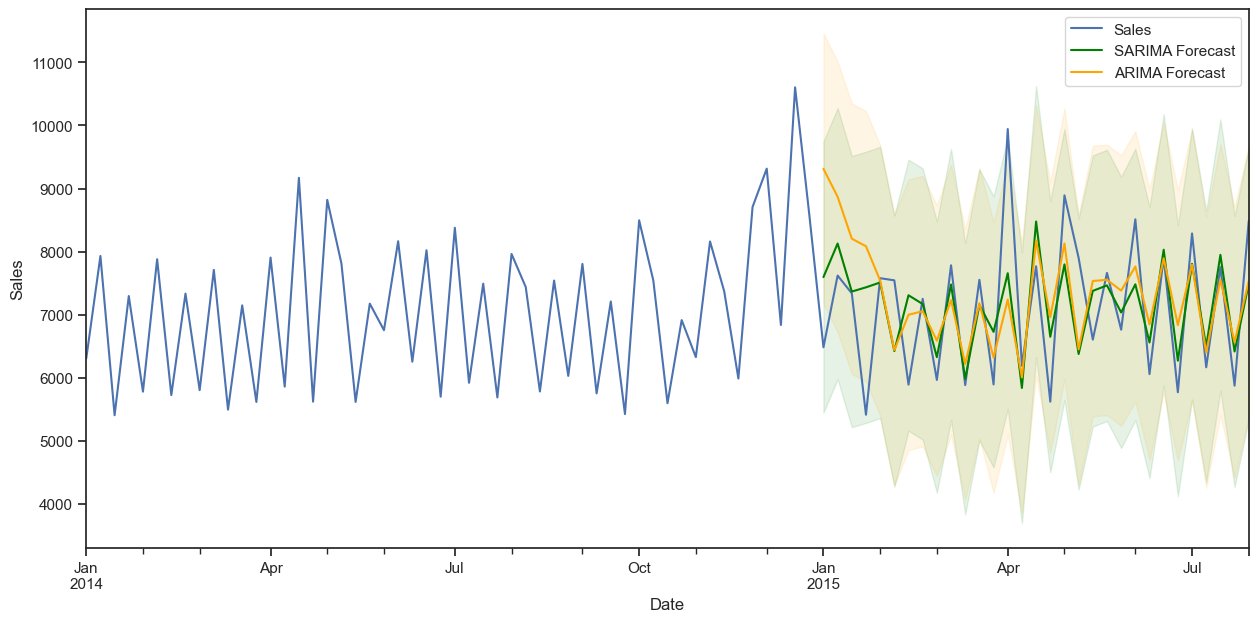

NameError: name 'forecast_df' is not defined

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from math import sqrt

from statsmodels.tsa.stattools import acf, pacf
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
from pmdarima.arima import auto_arima
from pandas.plotting import autocorrelation_plot

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error,mean_squared_error

from pandas.tseries.holiday import get_calendar, HolidayCalendarFactory, GoodFriday
from datetime import date

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

from prophet import Prophet
import holidays
import tensorflow as tf

from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings("ignore")

# Data Loading
df = pd.read_csv("train.csv", parse_dates=True, low_memory=False, index_col='Date')
store = pd.read_csv("store.csv", low_memory=False)

# Preprocessing
df.index
df['Year'] = df.index.year
df['Month'] = df.index.month
df['Day'] = df.index.day
df['SalePerCustomer'] = df['Sales'] / df['Customers']

# Plotting ECDFs
sns.set(style="ticks")
c = '#386B7F'
plt.figure(figsize=(12, 6))

plt.subplot(311)
cdf = ECDF(df['Sales'])
plt.plot(cdf.x, cdf.y, label="statmodels", color=c)
plt.xlabel('Sales')
plt.ylabel('ECDF')

plt.subplot(312)
cdf = ECDF(df['Customers'])
plt.plot(cdf.x, cdf.y, label="statmodels", color=c)
plt.xlabel('Customers')

plt.subplot(313)
cdf = ECDF(df['SalePerCustomer'])
plt.plot(cdf.x, cdf.y, label="statmodels", color=c)
plt.xlabel('Sale per Customer')

plt.show()

# Handling missing data
df = df[(df["Open"] != 0) & (df['Sales'] != 0)]
store['CompetitionDistance'].fillna(store['CompetitionDistance'].median(), inplace=True)
store.fillna(0, inplace=True)


# Merging datasets
df_merged = pd.merge(df, store, on='Store', how='inner')

# Visualization
frame, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(20, 16))
sales_a = df[df.Store == 2]['Sales']
sales_b = df[df.Store == 85]['Sales'].sort_index(ascending=True)
sales_c = df[df.Store == 1]['Sales']
sales_d = df[df.Store == 13]['Sales']

sales_a.resample('w').sum().plot(ax=ax1)
sales_b.resample('w').sum().plot(ax=ax2)
sales_c.resample('w').sum().plot(ax=ax3)
sales_d.resample('w').sum().plot(ax=ax4)

plt.show()

# Stationarity Test
def test_stationarity(timeseries):
    roll_mean = timeseries.rolling(window=7).mean()
    roll_std = timeseries.rolling(window=7).std()
    
    plt.subplots(figsize=(16, 6))
    plt.plot(timeseries.resample('w').mean(), color='green', linewidth=3, label='Original')
    plt.plot(roll_mean.resample('w').mean(), color='orange', linewidth=3, label='Rolling Mean')
    plt.plot(roll_std.resample('w').mean(), color='yellow', linewidth=3, label='Rolling Std')
    plt.legend(loc='best')
    plt.show()
    
    result = adfuller(timeseries, autolag='AIC')
    print('ADF Statistics: %f' % result[0])
    print('P-value: %f' % result[1])
    for key, value in result[4].items():
        print(key, value)

test_stationarity(sales_a)

# Decomposition
def plot_timeseries(sales, StoreType):
    fig, axes = plt.subplots(2, 1, sharex=True, sharey=False, figsize=(20, 6))
    decomposition = seasonal_decompose(sales, model='additive', period=365)
    axes[1].plot(decomposition.seasonal, 'g', label='Seasonality')
    axes[1].legend(loc='upper left')
    axes[0].plot(decomposition.trend, label='Trend')
    axes[0].legend(loc='upper left')
    plt.title('Decomposition Plots')
    plt.show()

plot_timeseries(sales_a, 'a')

# Autocorrelation and Partial Autocorrelation
def auto_corr(sales):
    lag_acf = acf(sales, nlags=30)
    lag_pacf = pacf(sales, nlags=20, method='ols')
    
    plt.subplot(121)
    plt.plot(lag_acf)
    plt.axhline(y=0, linestyle='--', color='red')
    plt.axhline(y=1.96/np.sqrt(len(sales)), linestyle='--', color='red')
    plt.axhline(y=-1.96/np.sqrt(len(sales)), linestyle='--', color='red')
    plt.title('ACF')
    
    plt.subplot(122)
    plt.plot(lag_pacf)
    plt.axhline(y=0, linestyle='--', color='red')
    plt.axhline(y=1.96/np.sqrt(len(sales)), linestyle='--', color='red')
    plt.axhline(y=-1.96/np.sqrt(len(sales)), linestyle='--', color='red')
    plt.title('PACF')
    plt.show()

auto_corr(sales_a)

# ARIMA Model
df_arima = df[['Sales']].copy()
df_arima = df_arima.resample('w').mean()
df_arima.plot()
plt.title('Weekly Sales')
plt.show()

model = auto_arima(df_arima, seasonal=True, m=12, suppress_warnings=True)
print("ARIMA Order:", model.order)
print("Seasonal Order:", model.seasonal_order)

model_arima = sm.tsa.ARIMA(df_arima, order=(4,1,0))
results_arima = model_arima.fit()
results_arima.summary().tables[1]

pred_arima = results_arima.get_prediction(start=pd.to_datetime('2015-1-4'), dynamic=False)
train_arima_forecasted = pred_arima.predicted_mean
train_arima_truth = df_arima['2015-01-04':]

# Plotting
ax = df_arima['2014':].plot(label='Observed', figsize=(15, 7))
pred_arima.predicted_mean.plot(ax=ax, label='One step ahead Forecast', alpha=1)
ax.fill_between(pred_arima.conf_int().index,
                pred_arima.conf_int().iloc[:, 0],
                pred_arima.conf_int().iloc[:, 1],
                color='r', alpha=.1)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()
plt.show()

rms_arima = sqrt(mean_squared_error(train_arima_truth['Sales'], train_arima_forecasted))
print('Root Mean Squared Error = ', rms_arima)

# SARIMA Model
df_sarima = df_arima.copy()
model_sarima = sm.tsa.statespace.SARIMAX(df_sarima, order=(4,1,1), seasonal_order=(0,0,1,12), enforce_stationarity=False, enforce_invertibility=False)
results_sarima = model_sarima.fit()
pred_sarima = results_sarima.get_prediction(start=pd.to_datetime('2015-1-4'), dynamic=False)
train_sarima_forecasted = pred_sarima.predicted_mean
train_sarima_truth = df_sarima['2015-01-04':]

# Plotting SARIMA
ax = df_sarima['2014':].plot(label='Observed', figsize=(15, 7))
pred_sarima.predicted_mean.plot(ax=ax, label='One step ahead Forecast', alpha=1)
ax.fill_between(pred_sarima.conf_int().index,
                pred_sarima.conf_int().iloc[:, 0],
                pred_sarima.conf_int().iloc[:, 1],
                color='r', alpha=.1)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()
plt.show()

rms_sarima = sqrt(mean_squared_error(train_sarima_truth['Sales'], train_sarima_forecasted))
print('Root Mean Squared Error = ', rms_sarima)

# Combined Plot
ax = df_sarima['2014':].plot(label='Observed', figsize=(15, 7))
pred_sarima.predicted_mean.plot(ax=ax, label='SARIMA Forecast', alpha=1, color='green')
ax.fill_between(pred_sarima.conf_int().index, pred_sarima.conf_int().iloc[:, 0], pred_sarima.conf_int().iloc[:, 1], color='green', alpha=.1)
pred_arima.predicted_mean.plot(ax=ax, label='ARIMA Forecast', alpha=1, color='orange')
ax.fill_between(pred_arima.conf_int().index, pred_arima.conf_int().iloc[:, 0], pred_arima.conf_int().iloc[:, 1], color='orange', alpha=.1)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()
plt.show()

forecast_df = pd.DataFrame({'ARIMA Forecast': train_arima_forecasted, 'SARIMA Forecast': train_sarima_forecasted, 'Observed': train_sarima_truth['Sales']})
forecast_df


forecast_df.reset_index('Date', inplace=True)
forecast_df['Date'] = pd.to_datetime(forecast_df['Date'])
forecast_df.set_index('Date', inplace=True)


def calculate_errors(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return rmse, mae, mape


stat_df = pd.DataFrame(index=['ARIMA', 'SARIMA'], columns=['RMSE', 'MAE', 'MAPE'])

for model in ['ARIMA', 'SARIMA']:
    rmse, mae, mape = calculate_errors(forecast_df['Observed'], forecast_df[f'{model} Forecast'])
    stat_df.loc[model] = [rmse, mae, mape]
    
stat_df

In [17]:
%%time
forecast_df.reset_index('Date', inplace=True)
forecast_df['Date'] = pd.to_datetime(forecast_df['Date'])
forecast_df.set_index('Date', inplace=True)


def calculate_errors(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return rmse, mae, mape


stat_df = pd.DataFrame(index=['ARIMA', 'SARIMA'], columns=['RMSE', 'MAE', 'MAPE'])

for model in ['ARIMA', 'SARIMA']:
    rmse, mae, mape = calculate_errors(forecast_df['Observed'], forecast_df[f'{model} Forecast'])
    stat_df.loc[model] = [rmse, mae, mape]

CPU times: total: 0 ns
Wall time: 10 ms


In [18]:
stat_df

,RMSE,MAE,MAPE
ARIMA,1112.766362,841.044469,12.257684
SARIMA,886.307067,687.146543,9.839839
